We load the libraries required for our model analysis.  Models used are:

1. VGG16 (all layers frozen)
2. VGG16 (last layers unfrozen)
3. VGG16 (all layer trainable)
4. ResNet50
5. DenseNet121

The images are loaded into array of images, labels with scaling.  There are two labels for the images.  Parasitized and Uninfected.


### Importing Libraries

In [26]:
#Load libraries
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers.core import Flatten, Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
%matplotlib inline

We are resize all the images to 115 x 115

In [27]:
datagen = ImageDataGenerator(rescale=1./255)
train_path = '../input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train'

train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(115,115), 
                                                         classes=['Monkeypox','Others'], class_mode='categorical', 
                                                         batch_size=27560)

imgs, label = next(train_batches)
print(label.shape)
print(imgs.shape)

Found 2142 images belonging to 2 classes.
(2142, 2)
(2142, 115, 115, 3)


### Image Augmentation

We do image augmentation on the images. 

In [28]:
# We need to separate the data into train and test arrays 
X_train, X_test, y_train, y_test = train_test_split(imgs,label,test_size=0.3,random_state=42)

In [29]:

datagen = ImageDataGenerator(
        rotation_range=10,  # Rotate images randomly 
        zoom_range = 0.1, # Zoom images randomly
        width_shift_range=0.1,  # Horizontally shift images in random order
        height_shift_range=0.1  # Vertically shift images in random order
)

datagen.fit(X_train)

### Viewing data

We view a few of the images from each class in order to explore image data visually.  Visually we can see that Parasitized cells have spots, discoloration, and overall less cell consistency  than Uninfected cells.  This makes it easier to distinguish  between the cell types.

Monkeypox


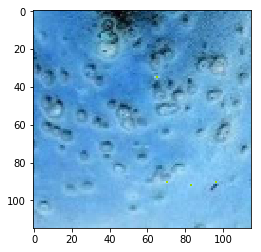

Others


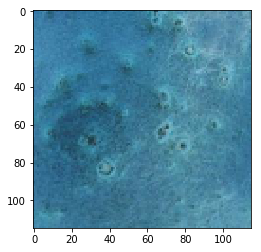

Others


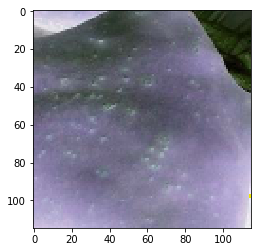

Others


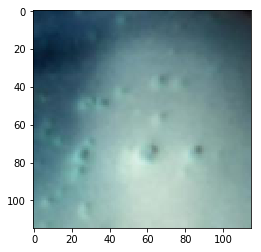

Monkeypox


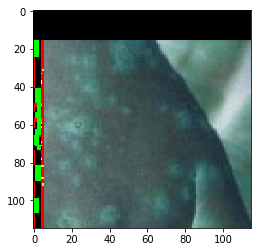

In [30]:
for i in range (0,5):
    image = imgs[i]
    plt.imshow((image * 255).astype(np.uint8))
    if (label[i][0]==1):
      print("Monkeypox")
    if (label[i][1]==1):
        print("Others")
    plt.show()

In [31]:
# Confusion Matrix
def show_confusion_matrix(history,model, x_test, y_test):
  
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'],loc='upper left')
  plt.show()

  pre_cls=model.predict_classes(x_test)   

  #Decode from one hot encoded to original for confusion matrix
  decoded_label = np.zeros(x_test.shape[0],)
  for i in range(y_test.shape[0]):
    decoded_label[i] = np.argmax(y_test[i])
  #print(decoded_label.shape)

  cm1 = confusion_matrix(decoded_label,pre_cls)
  print('Confusion Matrix : \n')
  print(cm1)

## Creating / Evaluating Model

### VGG16 Model - All Layers Frozen

VGG refers to a deep convolutional network for object recognition developed and trained by Oxford's renowned Visual Geometry Group (VGG), which achieved very good performance on the ImageNet dataset.

In [32]:
# model1 freeze all layers
# VGG16 pre-trained model
image_w, image_h = 115, 115
model1 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
model1.summary()

# Freezing all the layers
for layer in model1.layers[:]:
    layer.trainable = False
    
# Trainable layers   
print("Trainable Layers:")
for i, layer in enumerate(model1.layers):
    print(i, layer.name, layer.trainable)
    
# Adding custom layers to create a new model 
new_model = Sequential([
    model1,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dropout(0.5),
    Dense(2, activation='softmax', name='new_predictions')
])
new_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 115, 115, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 115, 115, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 115, 115, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 57, 57, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 57, 57, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 57, 57, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0         
__________

In [54]:
# Compiling the model - SGD Optimizer
new_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

#Fitting the model on the train data and labels.
print("Batch Size: 10, Epoch: 5, Optimizer: SGD")
new_model.fit(imgs, label, batch_size=10, epochs=5, verbose=1, validation_split=0.30, shuffle=True)

Batch Size: 10, Epoch: 5, Optimizer: SGD
Train on 1499 samples, validate on 643 samples
Epoch 1/5
1499/1499 [==============================] - 31s 21ms/step - loss: 0.0059 - acc: 0.9980 - val_loss: 0.4804 - val_acc: 0.9316
Epoch 2/5
1499/1499 [==============================] - 7s 4ms/step - loss: 0.0233 - acc: 0.9953 - val_loss: 0.4340 - val_acc: 0.9362
Epoch 3/5
1499/1499 [==============================] - 6s 4ms/step - loss: 0.0122 - acc: 0.9960 - val_loss: 0.4487 - val_acc: 0.9378
Epoch 4/5
1499/1499 [==============================] - 6s 4ms/step - loss: 0.0051 - acc: 0.9973 - val_loss: 0.4395 - val_acc: 0.9362
Epoch 5/5
1499/1499 [==============================] - 6s 4ms/step - loss: 0.0152 - acc: 0.9960 - val_loss: 0.4159 - val_acc: 0.9362


In [53]:
# Compiling the model - Adam Optimizer
new_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"])

#Fitting the model on the train data and labels.
print("Batch Size: 10, Epoch: 5, Optimizer: Adam")
new_model.fit(imgs, label, batch_size=10, epochs=5, verbose=1, validation_split=0.30, shuffle=True)


Batch Size: 10, Epoch: 5, Optimizer: Adam
Train on 1499 samples, validate on 643 samples
Epoch 1/5
1499/1499 [==============================] - 31s 20ms/step - loss: 0.0338 - acc: 0.9940 - val_loss: 0.4479 - val_acc: 0.9331
Epoch 2/5
1499/1499 [==============================] - 7s 4ms/step - loss: 0.0082 - acc: 0.9967 - val_loss: 0.5494 - val_acc: 0.9285
Epoch 3/5
1499/1499 [==============================] - 7s 4ms/step - loss: 0.0334 - acc: 0.9920 - val_loss: 0.4176 - val_acc: 0.9393
Epoch 4/5
1499/1499 [==============================] - 7s 4ms/step - loss: 0.0505 - acc: 0.9907 - val_loss: 0.5394 - val_acc: 0.9316
Epoch 5/5
1499/1499 [==============================] - 7s 4ms/step - loss: 0.0339 - acc: 0.9940 - val_loss: 0.4675 - val_acc: 0.9425


**VGG-16 All layers frozen using SGD optimizer--- accuracy=0.99, validation accuracy=0.93**
**and using Adam Optimizer--- accuracy=0.99, validation accuracy=0.94**

### VGG16 Model - Unfreeze Last Layer

In [37]:
#Model2 unfreeze last layer
# VGG16 pre-trained model without fully connected layers and with different input dimensions
image_w, image_h = 115, 115
model2 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
#model2.summary()

# Freezing the layers except the last one
for i, layer in enumerate(model2.layers):
  layer.trainable = False
  if (i >=15 ):
    layer.trainable = True

for i, layer in enumerate(model2.layers):
    print(i, layer.name, layer.trainable)
    
# Adding custom layers to create a new model 
new_model2 = Sequential([
    model2,
    Flatten(name='flatten'),
    Dense(512, activation='relu', name='new_fc1'),
    Dropout(0.5),
    Dense(2, activation='softmax', name='new_predictions')
])

0 input_8 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [52]:
# Compiling the model - SGD Optimizer
new_model2.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

#Fitting the model on the train data and labels.
print("Batch Size: 10, Epoch: 5, Optimizer: SGD")
new_model2.fit(imgs, label, batch_size=10, epochs=5, verbose=1, validation_split=0.30, shuffle=True)

Batch Size: 10, Epoch: 5, Optimizer: SGD
Train on 1499 samples, validate on 643 samples
Epoch 1/5
1499/1499 [==============================] - 62s 41ms/step - loss: 0.1234 - acc: 0.9526 - val_loss: 0.0632 - val_acc: 0.9782
Epoch 2/5
1499/1499 [==============================] - 19s 13ms/step - loss: 0.1096 - acc: 0.9573 - val_loss: 0.0635 - val_acc: 0.9751
Epoch 3/5
1499/1499 [==============================] - 19s 12ms/step - loss: 0.1370 - acc: 0.9466 - val_loss: 0.0622 - val_acc: 0.9751
Epoch 4/5
1499/1499 [==============================] - 19s 13ms/step - loss: 0.1222 - acc: 0.9520 - val_loss: 0.0591 - val_acc: 0.9736
Epoch 5/5
1499/1499 [==============================] - 19s 12ms/step - loss: 0.1178 - acc: 0.9506 - val_loss: 0.0591 - val_acc: 0.9720


**VGG16 Model - Unfreeze Last Layer--- accuracy = 0.95 and validation accuracy = 0.97**

### VGG16 Model - All Layers Trainable 

In [39]:
#Model2 unfreeze last layer
# VGG16 pre-trained model without fully connected layers and with different input dimensions
image_w, image_h = 115, 115
model2 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
#model2.summary()

# Freezing the layers except the last one
for i, layer in enumerate(model2.layers):
  layer.trainable = True
  
for i, layer in enumerate(model2.layers):
    print(i, layer.name, layer.trainable)
    
# Adding custom layers to create a new model 
new_model2 = Sequential([
    model2,
    Flatten(name='flatten'),
    Dense(512, activation='relu', name='new_fc1'),
    Dropout(0.5),
    Dense(2, activation='softmax', name='new_predictions')
])
    

0 input_9 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [51]:
# Compiling the model - Adam Optimizer
new_model2.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.00001), metrics=["accuracy"])

#Fitting the model on the train data and labels.
print("Batch Size: 10, Epoch: 5, Optimizer: Adam")
new_model2.fit(imgs, label, batch_size=10, epochs=5, verbose=1, validation_split=0.30, shuffle=True)

Batch Size: 10, Epoch: 5, Optimizer: Adam
Train on 1499 samples, validate on 643 samples
Epoch 1/5
1499/1499 [==============================] - 73s 49ms/step - loss: 0.2723 - acc: 0.8906 - val_loss: 0.0827 - val_acc: 0.9658
Epoch 2/5
1499/1499 [==============================] - 22s 15ms/step - loss: 0.1938 - acc: 0.9239 - val_loss: 0.0714 - val_acc: 0.9736
Epoch 3/5
1499/1499 [==============================] - 22s 15ms/step - loss: 0.1938 - acc: 0.9286 - val_loss: 0.0728 - val_acc: 0.9736
Epoch 4/5
1499/1499 [==============================] - 22s 15ms/step - loss: 0.1420 - acc: 0.9453 - val_loss: 0.0662 - val_acc: 0.9782
Epoch 5/5
1499/1499 [==============================] - 22s 15ms/step - loss: 0.1284 - acc: 0.9520 - val_loss: 0.0634 - val_acc: 0.9751


**VGG16 Model - All Layers Trainable --- accuracy = 0.95 and validation accuracy = 0.97**

### ResNet 50 Model - All Layers Trainable

ResNet is a short name for Residual Network. As the name of the network indicates, the new terminology that this network introduces is residual learning.

ResNet is the Convolutional Neural Netwrks by Microsoft team that won ILSRVC 2015 competition and surpass the human performance on ImageNet dataset. REsNet 50 is one of the versions provided in experiments.

In [41]:
image_w, image_h = 115, 115
model = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_w, image_h, 3))

model.summary()    
    # Adding custom layers to create a new model 
new_model2 = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(512, activation='relu', name='new_fc1'),
    Dropout(0.5),
    Dense(2, activation='softmax', name='new_predictions')
])
#new_model2.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 115, 115, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 121, 121, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 58, 58, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 58, 58, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

**Early Stopping**
Early stopping is a technique to avoid overfitting. Where we see if the validation accuracy is getting worse after few epochs, we stopping the training procedure

In [42]:
# Compiling the model - Adam Optimizer
new_model2.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.00001), metrics=["accuracy"])
es = keras.callbacks.EarlyStopping(monitor='val_acc', verbose=1, mode='max', patience=2)

Epoch 1/10
14/14 [==============================] - 5s 371ms/step - loss: 0.1770 - acc: 0.9279 - val_loss: 0.1614 - val_acc: 0.9425
Epoch 2/10
14/14 [==============================] - 5s 353ms/step - loss: 0.1770 - acc: 0.9271 - val_loss: 0.1599 - val_acc: 0.9471
Epoch 3/10
14/14 [==============================] - 5s 332ms/step - loss: 0.1551 - acc: 0.9350 - val_loss: 0.1566 - val_acc: 0.9502
Epoch 4/10
14/14 [==============================] - 5s 334ms/step - loss: 0.1463 - acc: 0.9421 - val_loss: 0.1503 - val_acc: 0.9518
Epoch 5/10
14/14 [==============================] - 5s 330ms/step - loss: 0.1418 - acc: 0.9493 - val_loss: 0.1444 - val_acc: 0.9518
Epoch 6/10
14/14 [==============================] - 5s 337ms/step - loss: 0.1415 - acc: 0.9378 - val_loss: 0.1370 - val_acc: 0.9565
Epoch 7/10
14/14 [==============================] - 5s 336ms/step - loss: 0.1268 - acc: 0.9500 - val_loss: 0.1343 - val_acc: 0.9580
Epoch 8/10
14/14 [==============================] - 5s 333ms/step - loss: 0.

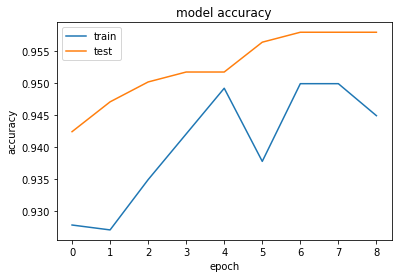

Confusion Matrix : 

[[268  20]
 [  7 348]]


In [50]:
#Fitting the model on the train data and labels.
batch_size = 100
history = new_model2.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=10, validation_data = (X_test, y_test), verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[es])

print("Batch Size: 20, Epoch: 5, Optimizer: Adam")

show_confusion_matrix(history,new_model2, X_test, y_test)

**ResNet 50 Model - All Layers Trainable --- accuracy = 0.94 and validation accuracy = 0.95**

### Densenet 121 - All Layers Trainable

In DenseNet, each layer obtains additional inputs from all preceding layers and passes on its own feature-maps to all subsequent layers. Concatenation is used. Each layer is receiving a “collective knowledge” from all preceding layers.

In [44]:
image_w, image_h = 115, 115
model = keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(image_w, image_h, 3))

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
model.summary()    
    # Adding custom layers to create a new model 
new_model2 = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(512, activation='relu', name='new_fc1'),
    Dropout(0.5),
    Dense(2, activation='softmax', name='new_predictions')
])
#new_model2.summary()

0 input_11 False
1 zero_padding2d_3 True
2 conv1/conv True
3 conv1/bn True
4 conv1/relu True
5 zero_padding2d_4 True
6 pool1 True
7 conv2_block1_0_bn True
8 conv2_block1_0_relu True
9 conv2_block1_1_conv True
10 conv2_block1_1_bn True
11 conv2_block1_1_relu True
12 conv2_block1_2_conv True
13 conv2_block1_concat True
14 conv2_block2_0_bn True
15 conv2_block2_0_relu True
16 conv2_block2_1_conv True
17 conv2_block2_1_bn True
18 conv2_block2_1_relu True
19 conv2_block2_2_conv True
20 conv2_block2_concat True
21 conv2_block3_0_bn True
22 conv2_block3_0_relu True
23 conv2_block3_1_conv True
24 conv2_block3_1_bn True
25 conv2_block3_1_relu True
26 conv2_block3_2_conv True
27 conv2_block3_concat True
28 conv2_block4_0_bn True
29 conv2_block4_0_relu True
30 conv2_block4_1_conv True
31 conv2_block4_1_bn True
32 conv2_block4_1_relu True
33 conv2_block4_2_conv True
34 conv2_block4_concat True
35 conv2_block5_0_bn True
36 conv2_block5_0_relu True
37 conv2_block5_1_conv True
38 conv2_block5_1_bn Tr

In [45]:
# Compiling the model - Adam Optimizer
new_model2.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.00001), metrics=["accuracy"])
es = keras.callbacks.EarlyStopping(monitor='val_acc', verbose=1, mode='max', patience=2)

Epoch 1/10
14/14 [==============================] - 5s 381ms/step - loss: 0.3063 - acc: 0.8779 - val_loss: 0.2153 - val_acc: 0.9114
Epoch 2/10
14/14 [==============================] - 5s 346ms/step - loss: 0.2888 - acc: 0.8727 - val_loss: 0.2056 - val_acc: 0.9191
Epoch 3/10
14/14 [==============================] - 5s 339ms/step - loss: 0.2819 - acc: 0.8792 - val_loss: 0.1960 - val_acc: 0.9222
Epoch 4/10
14/14 [==============================] - 5s 330ms/step - loss: 0.2576 - acc: 0.8963 - val_loss: 0.1909 - val_acc: 0.9191
Epoch 5/10
14/14 [==============================] - 5s 336ms/step - loss: 0.1965 - acc: 0.9142 - val_loss: 0.1790 - val_acc: 0.9285
Epoch 6/10
14/14 [==============================] - 5s 340ms/step - loss: 0.2074 - acc: 0.9042 - val_loss: 0.1734 - val_acc: 0.9347
Epoch 7/10
14/14 [==============================] - 5s 335ms/step - loss: 0.1976 - acc: 0.9142 - val_loss: 0.1702 - val_acc: 0.9393
Epoch 8/10
14/14 [==============================] - 5s 351ms/step - loss: 0.

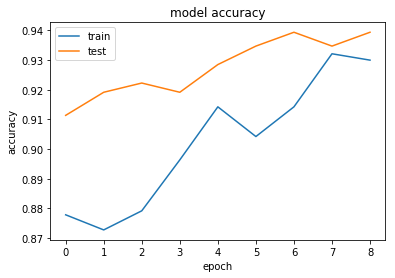

Confusion Matrix : 

[[259  29]
 [ 10 345]]


In [48]:
#Fitting the model on the train data and labels.
batch_size = 100
history = new_model2.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=10, validation_data = (X_test, y_test), verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[es])
print("Batch Size: 20, Epoch: 5, Optimizer: Adam")

show_confusion_matrix(history,new_model2, X_test, y_test)

**Densenet 121 - All Layers Trainable --- accuracy = 0.92 and validation accuracy = 0.93**

## Conclusion

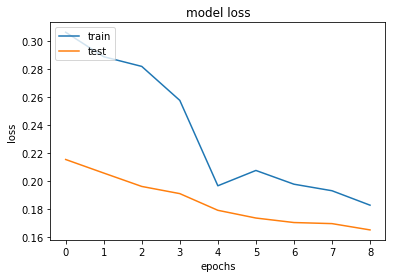

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

- ** VGG16 ** 
  - Validation Accuracy: 0.9650
- ** ResNet 50** 
  - Validation Accuracy: 0.9642
- ** DenseNet 121**
  - Validation Accuracy: 0.9612

Model accuracy stabilizes after few epochs and so is validation accuracy


As we can see from the above results that to train on few models, we are getting a accuracy of ~96% which is amazing.

We are also planning to upload our notebook on Kaggle

## References

[1]: World Health Organization, Fact Sheet: World Malaria Report 2016, https://www.who.int/malaria/media/world-malaria-report-2016/en/ (13 December 2016).

[2]: P. vivax (malaria) infected human blood smears, https://data.broadinstitute.org/bbbc/BBBC041/

[3]: A. Rosebrock, Deep Learning and Medical Image Analysis (2017), https://www.pyimagesearch.com/2018/12/03/deep-learning-and-medical-image-analysis-with-keras/

[4]: Gracelyn Shi, Detecting malaria using deep learning, https://towardsdatascience.com/detecting-malaria-using-deep-learning-fd4fdcee1f5a

[5]: Manu Siddhartha, Regularization Techniques in Deep Learning, https://www.kaggle.com/sid321axn/regularization-techniques-in-deep-learning

